# Generating Faces using DCGAN's

### Problem Statement : 
1. Generative Adversarial Models belong to a set of generative models which are used for generating content.
2. This project is an implementation of DCGAN with slight modifications to the actual architecture, to generate faces from random noise after training from a given set of gray scale face images.
3. GAN's is a combination of two models ,a generator which gnerates image from noise and a discriminator or adversary which validates whether the generated image is real or fake.



In [55]:
#Import Keras,numpy,opencv,matplotlib,os and glob libraries
from keras.models import Sequential
from keras.layers import ReLU,Reshape,Input,Activation, Flatten, Dropout, Dense, Add, AveragePooling2D,LeakyReLU,UpSampling2D
from keras.layers.convolutional import Conv2DTranspose,Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import  BatchNormalization
from keras import backend as K
from keras.initializers import glorot_uniform
from keras.models import Model, load_model
import numpy as np
K.set_image_data_format('channels_last')
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import cv2
import os,sys
from glob import glob

## Step 1 : Data Pre-Processing:

1. The dataset used for training consists of approx  13,000 cropped face images which was ideally created for emotion recognition. The dataset can be found at the below location.
https://github.com/muxspace/facial_expressions
2. The data was initially pre-processed by converting it into grayscale and resizing it to a fixed size of 56*56, also some images which weren't fixed for the task were manually removed.
3. The pixel values were then normalized to have values from -1 to 1, since our generator model includes a tanh function.
4. An extra axis was added to also denote the no of channels which is 1 in our case since they are gray scale images.
5. A sample set of training images can be viewed below.

              Training Images


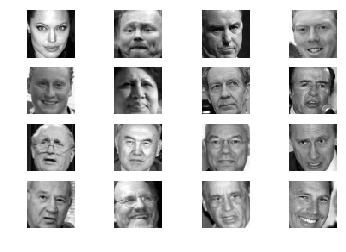

In [56]:
#Process the face images stored in the folder, resize it and convert it into numpy array.
folder = "dataset"
images = glob(os.path.join(folder, '*'))

# pre-processing images
def proc_images():

    x = []
    #set height and width of output image
    WIDTH =  56 
    HEIGHT = 56 

    for img in images:
        base = os.path.basename(img)


        #Read and resize image
        full_size_image = cv2.imread(img)
        gray = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2GRAY)
        x.append(cv2.resize(gray, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

    return x

# display images
def disp_imgs(imgs):
    
    fig, axs = plt.subplots(4, 4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(imgs[cnt], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    print("              Training Images")
    plt.show()
    plt.close()

x = proc_images()
disp_imgs(x[:16])
#Training data which will be fed to the GAN model.
train_X_o = np.array(x)
#scale the pixel values from 0 to 255 to -1 to 1
train_X_o = train_X_o/127.5 - 1
#adding one more dimension for channels
train_X_o = np.expand_dims(train_X_o, axis = 3)


## Step 2 : Build the Discriminator Model

1. The discriminator validates whether the generated image is real or fake.
2. The architecture is similar to that of a normal convolutional network.
3. The architecture used in this project consists of 5 layers.
4. The model takes a (56,56,1) size input image and outputs a classification result of 1 or 0 which indicates real or fake.
5. It uses leaky relu activation units,binary cross entropy loss function and a adam optimizer.
7. Dropout Layers are added to prevent overfitting.
6. The model architecture can be viewed in the summary below displayed after the code.

In [57]:
#build the discriminator model
def discriminator(input_shape):
    
   X_input = Input(input_shape)
   dmodel = Sequential()
   dmodel.add(Conv2D(32, kernel_size=3,strides = 2,padding = 'same', kernel_initializer = glorot_uniform(seed=0),input_shape=input_shape))
   dmodel.add(LeakyReLU(alpha=0.2))
   dmodel.add(Dropout(0.25))
    
   dmodel.add(Conv2D(64, kernel_size = 3, strides = 2,padding = 'valid', kernel_initializer = glorot_uniform(seed=0)))
   dmodel.add(BatchNormalization(momentum=0.8))
   dmodel.add(LeakyReLU(alpha=0.2))
   dmodel.add(Dropout(0.25))
        
   dmodel.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = 2,padding = 'same', kernel_initializer = glorot_uniform(seed=0)))
   dmodel.add(BatchNormalization(momentum=0.8))
   dmodel.add(LeakyReLU(alpha=0.2))
   dmodel.add(Dropout(0.25))

   dmodel.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = 1,padding = 'same', kernel_initializer = glorot_uniform(seed=0)))
   dmodel.add(BatchNormalization(momentum=0.8))
   dmodel.add(LeakyReLU(alpha=0.2))
   dmodel.add(Dropout(0.25))
    
   dmodel.add(Conv2D(filters = 512, kernel_size = (3, 3), strides = 1,padding = 'same', kernel_initializer = glorot_uniform(seed=0)))
   dmodel.add(BatchNormalization(momentum=0.8))
   dmodel.add(LeakyReLU(alpha=0.2))
   dmodel.add(Dropout(0.25))
 
   dmodel.add(Flatten())
   dmodel.add(Dense(1, activation='sigmoid'))
   
   dmodel.summary()

   real = dmodel(X_input)
   
   return Model(X_input, real)

discriminatorV = discriminator(input_shape = (56, 56,1))
#Adam optimizer is used for trianing and loss is calculated using binary cross entropy
discriminatorV.compile(loss='binary_crossentropy',optimizer=Adam(0.0002, 0.5),metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_28 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 13, 13, 64)        0         
__________

## Step 3: Build the Generator model 

1. The generator model takes random noise (100,1) as input and generates face image.
2. It consists of 5 layers and uses transpose convolution layers which upsamples the image and performs convolution operation.
3. Batch Normalizaton layer is added to prevent overfitting and also let the layers train independent of other layers.
4. Relu activation function is used after every layer and a tanh activation at the last layer which gives the values of generated image in range of -1 to 1.




In [58]:
#build the generator model
def generator(input_shape):
    
    X_input = Input(input_shape)
    gmodel = Sequential()
    
    gmodel.add(Dense(7*7*128,activation="relu",kernel_initializer=glorot_uniform(seed=0),input_shape = input_shape))
    gmodel.add(Reshape((7, 7, 128)))
    gmodel.add(BatchNormalization())
    gmodel.add(ReLU())
    
    gmodel.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    gmodel.add(BatchNormalization(momentum=0.8))
    gmodel.add(ReLU())
    
    
    gmodel.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    gmodel.add(BatchNormalization(momentum=0.8))
    gmodel.add(ReLU())
    
    gmodel.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
    gmodel.add(BatchNormalization(momentum=0.8))
    gmodel.add(ReLU())

    gmodel.add(Conv2DTranspose(16, kernel_size=3, strides=1, padding='same'))
    gmodel.add(BatchNormalization(momentum=0.8))
    gmodel.add(ReLU())
    
    gmodel.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same'))
    gmodel.add(Activation("tanh"))
    
    gmodel.summary()
    img = gmodel(X_input)
    
    return Model(X_input,img)

generatorV = generator(input_shape = (100,))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_16 (ReLU)              (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_33 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_17 (ReLU)              (None, 14, 14, 128)       0         
__________

## Step 4 : Building the GAN Model:

1. The discriminator and generator is combined to build the GAN model.
2. The discriminator training is disabled while training the gan model, only the genrator is trained.
3. The generator takes input as noise and generates image which is then passed to discriminator to validate it as real or fake.
4. The GAN model is trained using Adam optimizer and binary cross entropy loss function.


In [59]:
#combine discriminator and generator to build GAN
def create_GAN(disc,gen):
    disc.trainable = False  #disable discriminator training while training combined model.
    z = Input(shape=(100,))
    img = gen(z) 
    gan_op = disc(img)  
    GANModel = Model(z,gan_op) 
    GANModel.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return GANModel

gan = create_GAN(discriminatorV,generatorV)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_11 (Model)             (None, 56, 56, 1)         879553    
_________________________________________________________________
model_10 (Model)             (None, 1)                 1596929   
Total params: 2,476,482
Trainable params: 878,817
Non-trainable params: 1,597,665
_________________________________________________________________


In [60]:
# saves the generated face image after every epoch.
def save_imgs(epoch,noise):
    r, c = 4, 4
    #noise = np.random.normal(0, 1, (5 * c, 100))
    gen_imgs = generatorV.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.jpg" % epoch)
    plt.show()
    plt.close()

## Step 5: Training the GAN model.

1. We create labels for fake data and real data.Fake data labels are set as zeros and real data as ones.
2. We train our model on 10000 epochs having a batch size of 32.
3. The traning process can be divided in two stages. In the first stage the discriminator is trained on real and fake images.
4. In the second stage the discriminator training is turned off and only the generator is trained and the discriminator just validates whether the generated image is fake or not.
5. So you have a double feedback loop:
   a. The discriminator is in a feedback loop with the ground truth of the images, which we know.
   b. The generator is in a feedback loop with the discriminator.
6. The Descriminator plots with respect to accuracy and loss and generator loss plots have been shown below.
7. The descriminator loss and accuracy indicated with what accuracy the discriminator is able to distinguish between real and fake images and the genrator loss indicates how similar the genrated image is to the actual image.


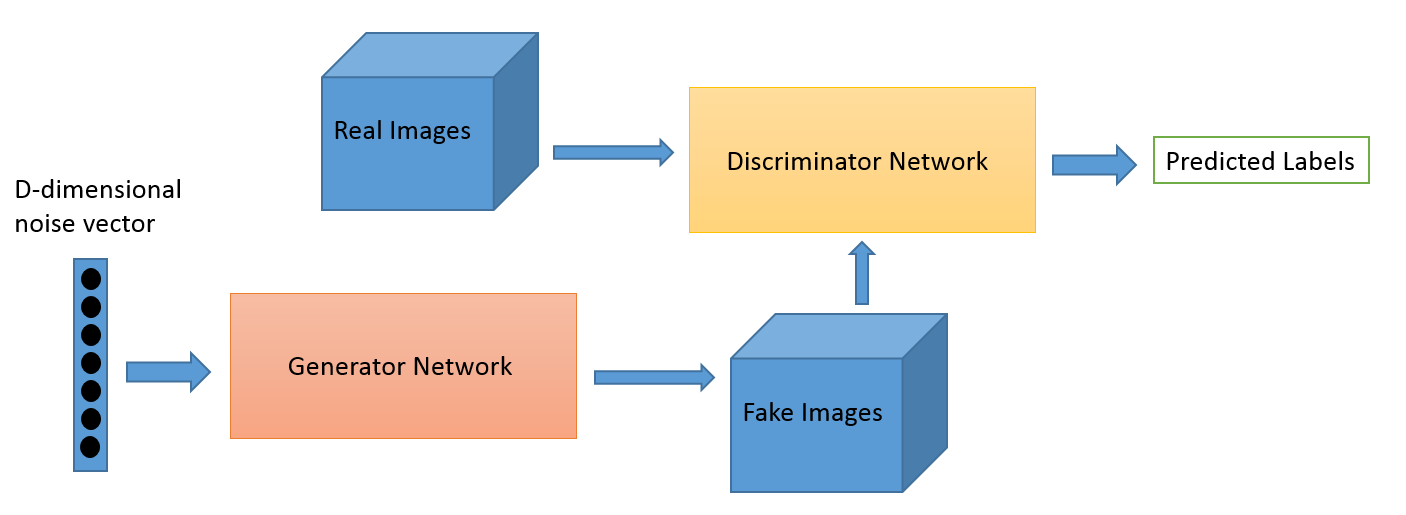              [Training GAN](https://skymind.ai/wiki/generative-adversarial-network-gan)

Epoch :  0


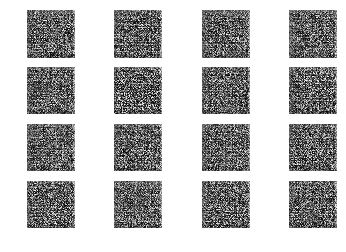

Epoch :  2000


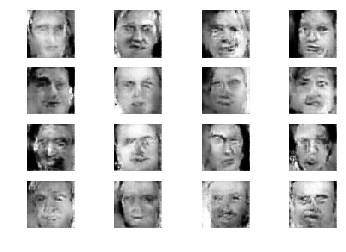

Epoch :  4000


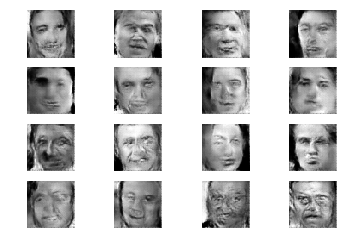

Epoch :  6000


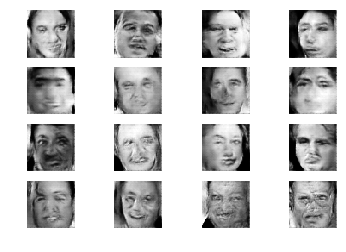

Epoch :  8000


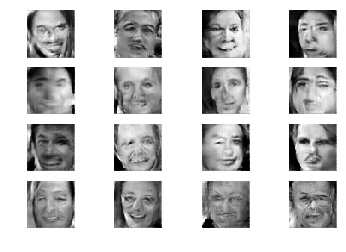

Epoch :  10000


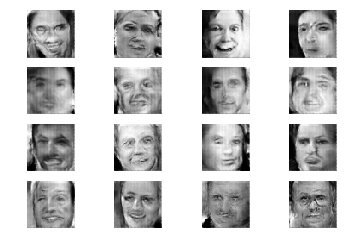

In [61]:
batch_size = 32
real_gd = np.ones((batch_size,1))
fake_gd = np.zeros((batch_size,1))
epochs = 10001
total_img = train_X_o.shape[0]
noise = np.random.normal(0, 1, (4*4, 100))
disc_acc = []
disc_loss = []
gentr_loss = []
for epoch in range(epochs):
    
    idx = np.random.randint(0, total_img, batch_size)
    train_imgs = train_X_o[idx]
    
    noise_image = np.random.normal(0,1,[batch_size,100])
    genimg = generatorV.predict_on_batch(noise_image)
    discriminatorV.trainable = True
    #train the discriminator on real and fake images. 
    dis_loss_real = discriminatorV.train_on_batch(train_imgs,real_gd)  
    dis_loss_fake = discriminatorV.train_on_batch(genimg,fake_gd)
    dis_loss = 0.5*np.add(dis_loss_real,dis_loss_fake)
    #disable discriminator while traning GAN
    discriminatorV.trainable = False
    gen_loss = gan.train_on_batch(noise_image,real_gd)
    
    #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, dis_loss[0], 100*dis_loss[1], gen_loss[0]))
    disc_acc.append(100*dis_loss[1])
    disc_loss.append(dis_loss[0])
    gentr_loss.append(gen_loss[0])
    #predict on the generator while training and save the images
    if epoch % 2000 == 0:
        print('Epoch : ',epoch)
        save_imgs(epoch,noise)
    
 


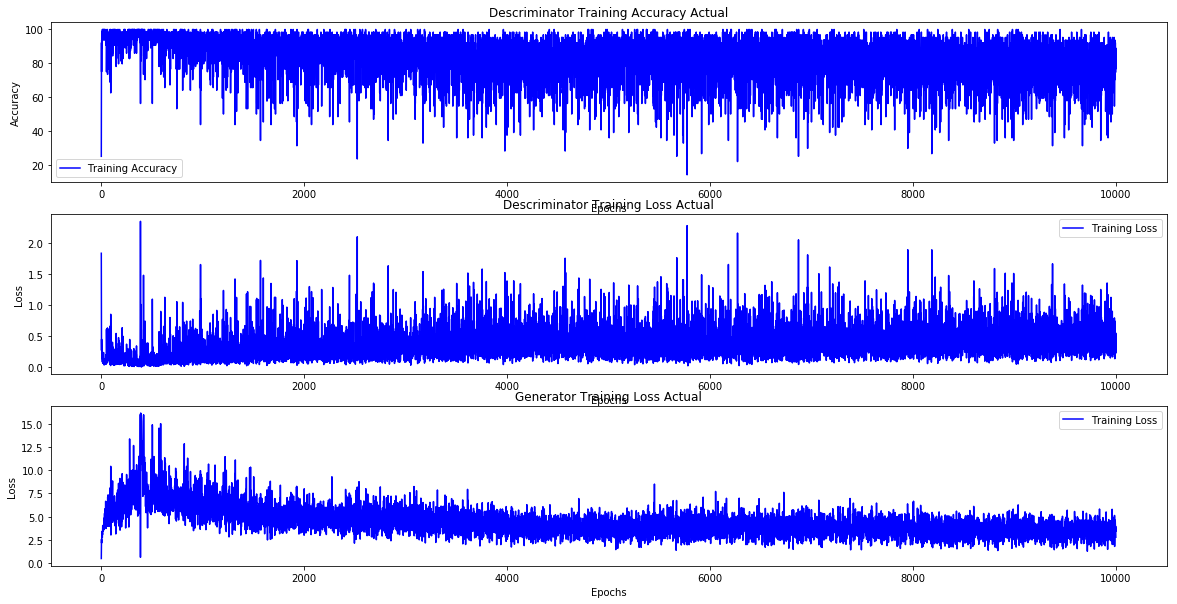

In [62]:
f, ax = plt.subplots(3, 1, figsize=(20, 10))

# Plot 5 curves on the same plot
indices = np.float32(range(epochs))

ax[0].plot(indices, disc_acc, 'b',label=r'Training Accuracy') 
ax[0].set_title("Descriminator Training Accuracy Actual")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend();
print(" ")


indices = np.float32(range(epochs))
#
ax[1].plot(indices, disc_loss, 'b',label=r'Training Loss') 
ax[1].set_title("Descriminator Training Loss Actual")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend();  
print(" ")
    
indices = np.float32(range(epochs))
#
ax[2].plot(indices, gentr_loss, 'b',label=r'Training Loss') 
ax[2].set_title("Generator Training Loss Actual")
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(); 

References:

[1] https://skymind.ai/wiki/generative-adversarial-network-gan

[2] https://github.com/eriklindernoren/Keras-GAN/tree/master/

[3] https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

[4] https://arxiv.org/pdf/1511.06434.pdf